In [1]:
#TODO: combine the prc curves across forward/reverse 
## repeat for all simulations
## overlay simulations on the same plot. 
## color consistency.
## window overlap with motif needs to be 100% (not 80%) 

## check the ISM plot. 

## bootstrap the test set for error bars. 

## Positional PRC 

Window size = length of PWM 

Window overlap with motif threshold for positive = 0.8 

Window stride = 1


In [2]:
## If you are running this notebook in Google Colab, uncomment the code below 
## !pip install dragonn>=0.2.2

In [3]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [4]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from dragonn.positional_prc import * 
from dragonn.simulations import * 
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')



Using TensorFlow backend.


In [7]:

#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)


In [6]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
tal1_model=Sequential() 
tal1_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=tal1_data.X_train.shape[1::]))
tal1_model.add(Activation('relu'))
tal1_model.add(MaxPooling2D(pool_size=(1,35)))
tal1_model.add(Flatten())
tal1_model.add(Dense(1))
tal1_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
tal1_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history=tal1_model.fit(x=tal1_data.X_train,
                                  y=tal1_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=0,
                                  callbacks=[EarlyStopping(patience=3),
                                            History()],
                                  validation_data=(tal1_data.X_valid,
                                                   tal1_data.y_valid))


Instructions for updating:
Use tf.cast instead.


In [12]:
from dragonn.models import ClassificationResult
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=tal1_model.predict(tal1_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(tal1_data.y_test,test_predictions))

Loss: 0.3312	Balanced Accuracy: 88.78%	 auROC: 0.931	 auPRC Careful: 0.923	 auPRC Trapezoidal: 0.923
	Recall at 5%|10%|20% FDR: 28.1%|85.2%|94.6%	 Num Positives: 1994	 Num Negatives: 2006


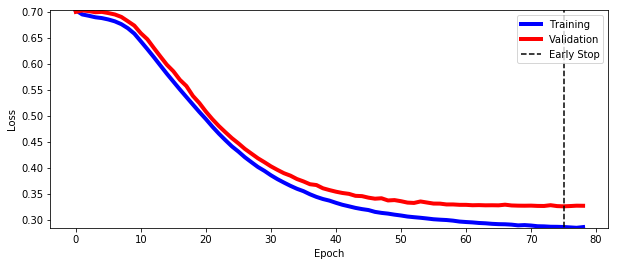

In [14]:
from dragonn.vis import * 
## Visualize the model's performance 
plot_learning_curve(history)

In [18]:
#get the indices of the positive examples -- we want to do a separate interpretation for positive examples only 
pos_indx=np.flatnonzero(tal1_data.y_valid==1)
pos_X=tal1_data.X_test[pos_indx]

### Motif scores (all)

In [20]:
motif_scores=get_motif_scores(tal1_data.X_test,tal1_data.motif_names)

In [23]:
motif_scores.shape

(4000, 1, 500)

In [27]:
motif_score_posPRC=positionalPRC(tal1_data.test_embeddings,motif_scores)

#plot_positionalPRC(motif_score_posPRC)

In [38]:
motif_score_posPRC['TAL1_known4'][2]

0.05641858472141727

### Motif scores (positives)

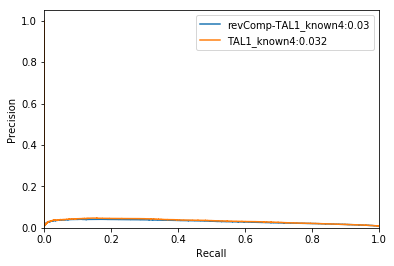

In [12]:
motif_score_posPRC=positionalPRC([simulation_data.valid_embeddings[i] for i in pos_indx],motif_scores[pos_indx])
plot_positionalPRC(motif_score_posPRC)

### In silico mutagenesis (all)

In [13]:
from dragonn.tutorial_utils import in_silico_mutagenesis, plot_ism
ism_vals=in_silico_mutagenesis(regularized_keras_model,simulation_data.X_valid)
#take the maximum along the third axis of the absolute values -- we care only about magnitude of change 
ism_collapsed=np.max(abs(ism_vals),axis=2)
print(ism_collapsed.shape)


(1000, 1500)


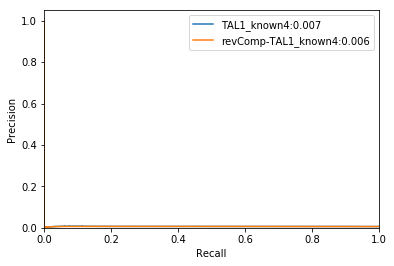

In [14]:
ism_posPRC=positionalPRC(simulation_data.valid_embeddings,ism_collapsed)
plot_positionalPRC(ism_posPRC)



### In silico mutagenesis (positives)

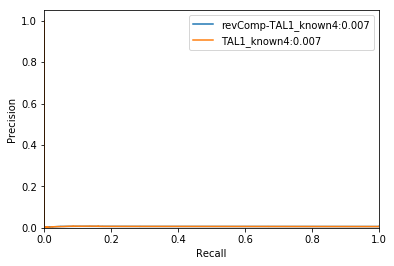

In [15]:
ism_posPRC=positionalPRC([simulation_data.valid_embeddings[i] for i in pos_indx],ism_collapsed[pos_indx])
plot_positionalPRC(ism_posPRC)

### Gradient x Input (all)

In [20]:
from dragonn.tutorial_utils import  input_grad,plot_seq_importance
gradxinput=input_grad(regularized_keras_model,simulation_data.X_valid)*simulation_data.X_valid
gradxinput=np.squeeze(gradxinput)
gradxinput_collapsed=np.max(gradxinput,axis=2)
print(gradxinput_collapsed.shape)

(1000, 1500)


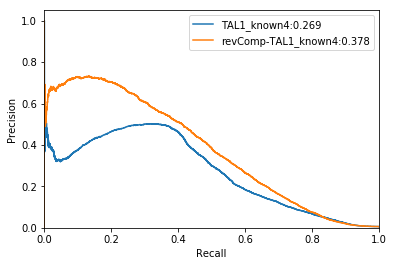

In [21]:
gradxinput_PRC=positionalPRC(simulation_data.valid_embeddings,gradxinput_collapsed)
plot_positionalPRC(gradxinput_PRC)

### Gradient x Input (positives)

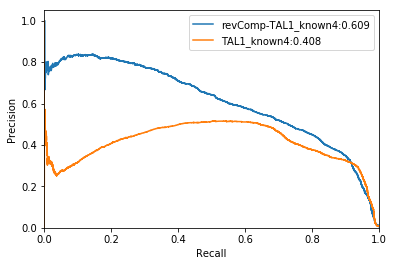

In [22]:
gradxinput_PRC=positionalPRC([simulation_data.valid_embeddings[i] for i in pos_indx],gradxinput_collapsed[pos_indx])
plot_positionalPRC(gradxinput_PRC)

### DeepLIFT (all)

In [23]:
from dragonn.tutorial_utils import deeplift
dl=deeplift(regularized_keras_model,simulation_data.X_valid)
dl=dl.squeeze() 
dl_collapsed=np.max(dl,axis=2)
print(dl_collapsed.shape)

(1000, 1500)


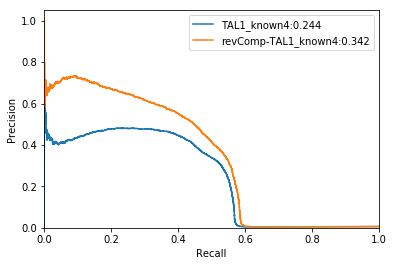

In [19]:
dl_PRC=positionalPRC(simulation_data.valid_embeddings,dl_collapsed)
plot_positionalPRC(dl_PRC)

### DeepLIFT (positives)

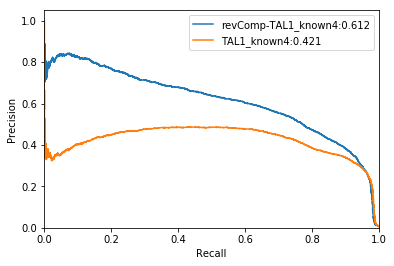

In [20]:
dl_PRC=positionalPRC([simulation_data.valid_embeddings[i] for i in pos_indx],dl_collapsed[pos_indx])
plot_positionalPRC(dl_PRC)